## Cell type classification by Sanghun Jee 
#[This part is not included in the bachelor thesis]

In [1]:
import numpy as np
import csv
import sys
import matplotlib.pyplot as plt
import pandas as pd
import tables
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
import seaborn as sns; sns.set()

In [3]:
# Load the exon dataset and sample file
exon_data = pd.read_csv('mouse_VISp_2018-06-14_exon-matrix.csv') #From Allen Brain Institute Data Folder
gene_median = np.median(exon_data, axis=1)
mean_median = np.mean(gene_median)
select_half_gene = np.where(gene_median>mean_median)
exon_data=exon_data.values[select_half_gene, :][0]
exon_data[exon_data==0]=1 #To prevent to make -inf when converting exon data to log2 scale
exon_filtered_log2 = pd.DataFrame(np.log2(exon_data))
del exon_data

## When I have limited RAM, I prefer to use hdf file (downsized)
#exon_filtered = pd.read_hdf('exon_filtered.h5', key='exon_filtered')
#exon_filtered_log2 = np.log2(exon_filtered)
#del exon_filtered

samples = pd.read_csv('mouse_VISp_2018-06-14_samples-columns.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


Let's do cell type(Glutamergic, Gabaergic and etc) classification at first

In [4]:
# Get each cell types indices
Glutamergic_ind = np.where(samples.iloc[:, -6]=='Glutamatergic')[0]
Gabaergic_ind = np.where(samples.iloc[:, -6]=='GABAergic')[0]
Gluta = exon_filtered_log2.iloc[:, Glutamergic_ind]
Gaba = exon_filtered_log2.iloc[:, Gabaergic_ind]

In [5]:
L1_ind = np.where(samples.values[:, 13] =='L1')[0]
L23_ind = np.where(samples.values[:, 13] =='L2/3')[0]
L4_ind = np.where(samples.values[:, 13] =='L4')[0]
L5_ind = np.where(samples.values[:, 13] =='L5')[0]
L6_ind = np.where(samples.values[:, 13] =='L6')[0]

In [6]:
#TO generate all combinations from the set a and b
def common_member(a, b): 
      
    a_set = set(a) 
    b_set = set(b) 
      
    # check length  
    if len(a_set.intersection(b_set)) > 0: 
        return(a_set.intersection(b_set))   
    else: 
        return("no common elements") 

Heatmap

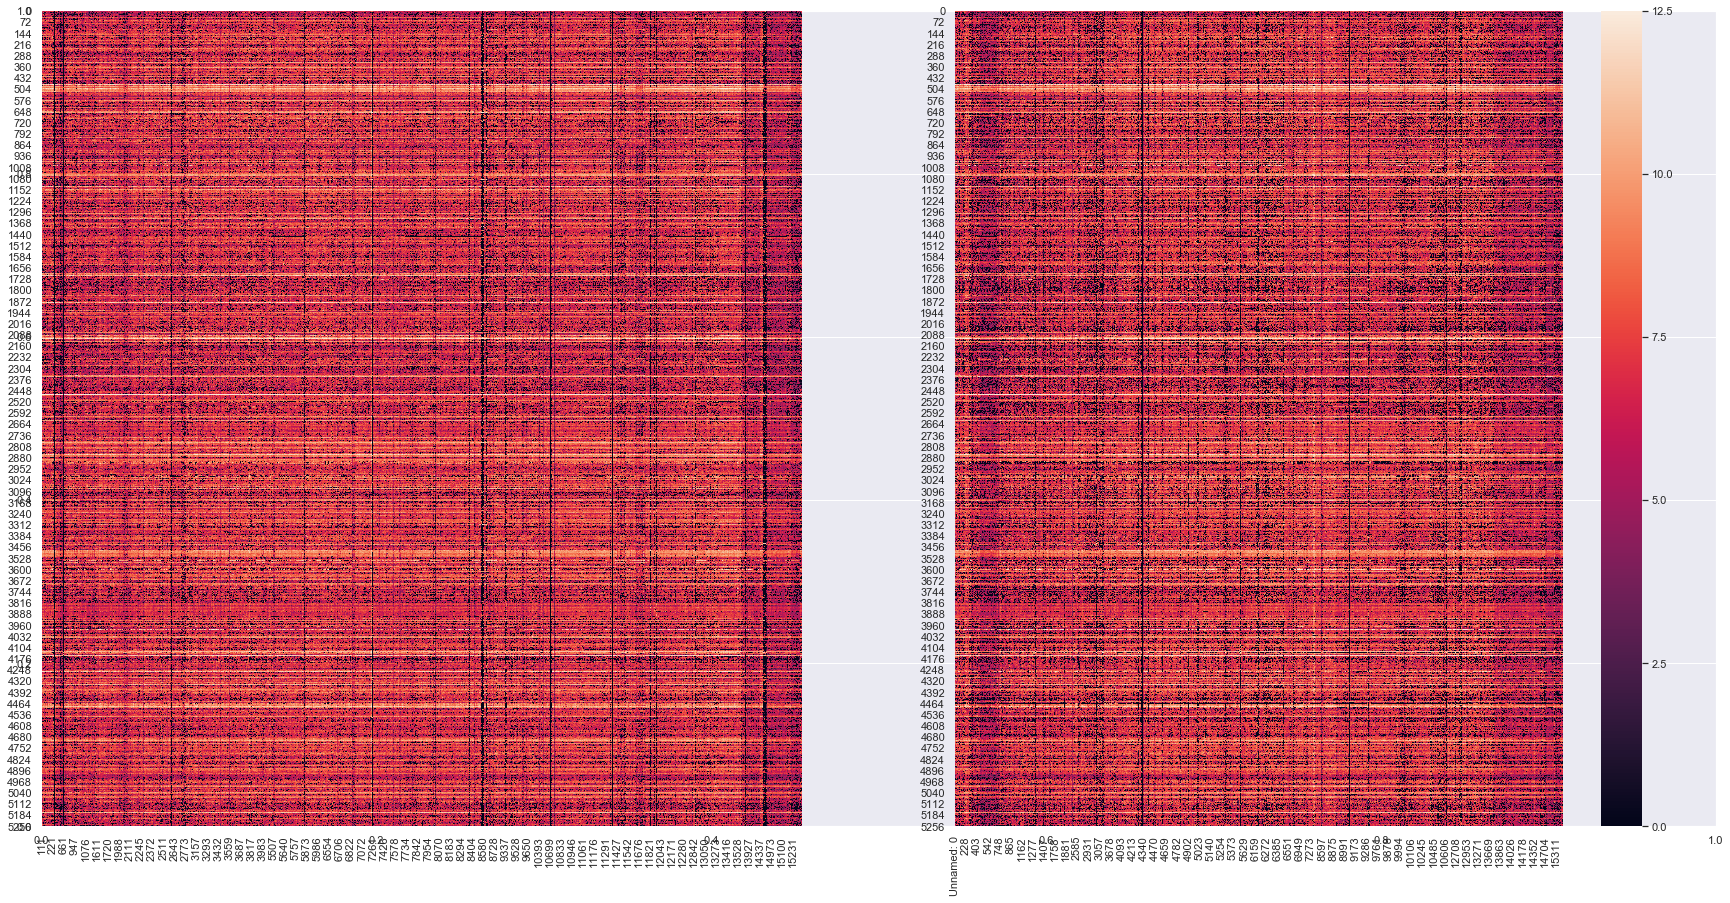

In [7]:
fig, _= plt.subplots(figsize=(30, 15))
ax1 = fig.add_subplot(1, 2, 1)
ax1 = sns.heatmap(Gluta, vmin=0, vmax=12.5, cbar=False) #Glutamergic cell's heatmap

ax2 = fig.add_subplot(1, 2, 2)
ax2 = sns.heatmap(Gaba, vmin=0, vmax=12.5) # Gabaergic cell's heatmap

#fig.savefig('Gluta_Gaba_heatmap.png')

Clustering

In [9]:
#Before do this clustering, I saw the dendrogram and decided the distance threshold to get around 7 clusters
Gluta_clustering = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=1750).fit(Gluta)
Gaba_clustering = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=1750).fit(Gaba)

In [10]:
#Get the label. So we know which gene is in which num of cluster
Gluta_label = Gluta_clustering.labels_
Gaba_label = Gaba_clustering.labels_

uniGluta_label = np.unique(Gluta_label)
uniGaba_label = np.unique(Gaba_label)

pre_Gluta = []
pre_Gaba = []
for i in range(0, len(uniGluta_label)):
    pre_Gluta.append(np.where(Gluta_label == uniGluta_label[i]))
    
for i in range(0, len(uniGaba_label)):
    pre_Gaba.append(np.where(Gaba_label == uniGaba_label[i]))
    

In [11]:
#MAke the cell types dataframe 
Gluta_clust = {}
for i in range(0, len(pre_Gluta)):
    Gluta_clust[i] = np.mean(Gluta.values[pre_Gluta[i][0], :], axis=0)
Gluta_clust = pd.DataFrame(Gluta_clust)

Gaba_clust = {}
for i in range(0, len(pre_Gaba)):
    Gaba_clust[i] = np.mean(Gaba.values[pre_Gaba[i][0], :], axis=0)
Gaba_clust = pd.DataFrame(Gaba_clust)

In [12]:
#Get whole possible numbers. This is for statistical test to know which clusters are significant.
from itertools import permutations, product
iter_Gluta = list(permutations(uniGluta_label, 2))
iter_Gaba = list(permutations(uniGaba_label, 2))
total_items = [uniGaba_label, uniGaba_label]
iter_total = list(product(*total_items))

In [13]:
# To make same dimension of sample.
Gluta_shrink = np.random.choice(np.arange(len(Gluta_clust)), size=len(Gaba_clust), replace=False)

In [14]:
#T-test_relative 
p_Gluta, p_Gaba, p_total = [], [], []
for i in iter_Gluta:
    _, p_val = stats.ttest_rel(Gluta_clust.values[:, i[0]], Gluta_clust.values[:, i[1]])
    p_Gluta.append(p_val)
for i in iter_Gaba:
    _, p_val = stats.ttest_rel(Gaba_clust.values[:, i[0]], Gaba_clust.values[:, i[1]])
    p_Gaba.append(p_val)
#for i in iter_total:
#  _, p_val = stats.ttest_rel(Gluta_clust.values[Gluta_shrink, i[0]], Gaba_clust.values[:, i[1]])
#  p_total.append(p_val)

Let's test it by machin learning

In [16]:
#MAke the cell types dataframe
Gluta_clust_all, Gaba_clust_all = {}, {}
for i in range(0, len(pre_Gluta)):
  Gluta_clust_all[i] = np.mean(exon_filtered_log2.iloc[pre_Gluta[i][0], :], axis=0)
  Gaba_clust_all[i] = np.mean(exon_filtered_log2.iloc[pre_Gaba[i][0], :], axis=0)
Gluta_clust_all = pd.DataFrame(Gluta_clust_all)
Gaba_clust_all = pd.DataFrame(Gaba_clust_all)
Total_clust = pd.DataFrame(np.hstack((Gluta_clust_all, Gaba_clust_all))) #This gonna be X

In [17]:
labels = np.zeros((len(Total_clust))) #So, there are three classes.
labels[Glutamergic_ind] = 1
labels[Gabaergic_ind] = 2

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Total_clust, labels, test_size = .15, train_size = .85)
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)

Using TensorFlow backend.


In [19]:
import tensorflow as tf
import keras
from keras.backend import tensorflow_backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
from keras import layers
from keras import regularizers
from keras import optimizers

In [20]:
model = Sequential()
model.add(Dense(y_train_binary.shape[0], input_shape=(X_train.shape[1],), activation='sigmoid'))
model.add(layers.BatchNormalization())
model.add(Dense(y_train_binary.shape[0], activation='sigmoid'))
model.add(layers.BatchNormalization())
# model.add(Dense(y_train_binary.shape[0], activation='sigmoid'))
# model.add(layers.BatchNormalization())
# model.add(Dense(y_train_binary.shape[0], activation='sigmoid'))
# model.add(layers.BatchNormalization())
# model.add(Dense(y_train_binary.shape[0]//4, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(y_train_binary.shape[0]//8, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(y_train_binary.shape[0]//16, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(Dropout(0.3))
#model.add(Dense(y_train_binary.shape[0]//16, activation='relu'))
model.add(Dense(y_train_binary.shape[1], activation='softmax'))

Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer= Adam, metrics=['accuracy'])
model.summary()
h = model.fit(X_train, y_train_binary, epochs = 1000, batch_size = X_train.shape[0], verbose=1, validation_split=0.1)

W1205 20:56:31.308032 11124 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1205 20:56:31.326280 11124 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1205 20:56:31.326280 11124 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1205 20:56:31.396327 11124 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1205 20:56:31.576629 11124 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13102)             196530    
_________________________________________________________________
batch_normalization_1 (Batch (None, 13102)             52408     
_________________________________________________________________
dense_2 (Dense)              (None, 13102)             171675506 
_________________________________________________________________
batch_normalization_2 (Batch (None, 13102)             52408     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 39309     
Total params: 172,016,161
Trainable params: 171,963,753
Non-trainable params: 52,408
_________________________________________________________________
Train on 11791 samples, validate on 1311 samples
Epoch 1/1000


ResourceExhaustedError: OOM when allocating tensor with shape[13102] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node batch_normalization_1/moving_mean/biased/Assign (defined at C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1014) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'batch_normalization_1/moving_mean/biased/Assign':
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 563, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 534, in run_forever
    self._run_once()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1771, in _run_once
    handle._run()
  File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-66ecfa2616d5>", line 3, in <module>
    model.add(layers.BatchNormalization())
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\sequential.py", line 181, in add
    output_tensor = layer(self.outputs[0])
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 457, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\layers\normalization.py", line 197, in call
    self.momentum),
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 1014, in moving_average_update
    x, value, momentum, zero_debias=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\moving_averages.py", line 107, in assign_moving_average
    return replica_context.merge_call(merge_fn, args=(variable, value))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py", line 1684, in merge_call
    return self._merge_call(merge_fn, args, kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py", line 1691, in _merge_call
    return merge_fn(self._strategy, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\moving_averages.py", line 105, in merge_fn
    return update(strategy, v, value)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\moving_averages.py", line 94, in update
    return _zero_debias(strategy, v, value, decay)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\moving_averages.py", line 237, in _zero_debias
    trainable=False)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1496, in get_variable
    aggregation=aggregation)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1239, in get_variable
    aggregation=aggregation)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 562, in get_variable
    aggregation=aggregation)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 514, in _true_getter
    aggregation=aggregation)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 929, in _get_single_variable
    aggregation=aggregation)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2511, in default_variable_creator
    shape=shape)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 1568, in __init__
    shape=shape)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 1745, in _init_from_args
    validate_shape=validate_shape).op
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\state_ops.py", line 227, in assign
    validate_shape=validate_shape)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 66, in assign
    use_locking=use_locking, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [0]:
# Ccompare whetehr the model can predict well for test set
pred = model.predict(X_test, batch_size=X_test.shape[0], verbose=1, steps=None)
np.where(pred[0] == np.max(pred[0]))
predict = []
max_label = np.max(pred, axis=1)
for i in range(0, len(max_label)):
  predict.append(np.where(pred[i] == max_label[i]))
predict = np.reshape(predict, (1, -1))[0]
from sklearn.metrics import accuracy_score
accuracy_score(predict, y_test)

In [0]:
#Save the model structure by png file
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [0]:
history = h
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
#Let's get the each components
L1_Gluta_ind = list(common_member(Glutamergic_ind, L1_ind))
L23_Gluta_ind = list(common_member(Glutamergic_ind, L23_ind))
L4_Gluta_ind = list(common_member(Glutamergic_ind, L4_ind))
L5_Gluta_ind = list(common_member(Glutamergic_ind, L5_ind))
L6_Gluta_ind = list(common_member(Glutamergic_ind, L6_ind))

L1_Gaba_ind = list(common_member(Gabaergic_ind, L1_ind))
L23_Gaba_ind = list(common_member(Gabaergic_ind, L23_ind))
L4_Gaba_ind = list(common_member(Gabaergic_ind, L4_ind))
L5_Gaba_ind = list(common_member(Gabaergic_ind, L5_ind))
L6_Gaba_ind = list(common_member(Gabaergic_ind, L6_ind))

In [22]:
#Get the each cell type and layers
L1_Gluta = exon_filtered_log2.values[:, L1_Gluta_ind]
L23_Gluta = exon_filtered_log2.values[:, L23_Gluta_ind]
L4_Gluta = exon_filtered_log2.values[:, L4_Gluta_ind]
L5_Gluta = exon_filtered_log2.values[:, L5_Gluta_ind]
L6_Gluta = exon_filtered_log2.values[:, L6_Gluta_ind]

L1_Gaba = exon_filtered_log2.values[:, L1_Gaba_ind]
L23_Gaba = exon_filtered_log2.values[:, L23_Gaba_ind]
L4_Gaba = exon_filtered_log2.values[:, L4_Gaba_ind]
L5_Gaba = exon_filtered_log2.values[:, L5_Gaba_ind]
L6_Gaba = exon_filtered_log2.values[:, L6_Gaba_ind]

In [23]:
#To get the clustering dendrogram
Z_L1_Gluta_ind = ward(exon_filtered_log2.iloc[:, L1_Gluta_ind])
Z_L23_Gluta_ind = ward(exon_filtered_log2.iloc[:, L23_Gluta_ind])
Z_L4_Gluta_ind = ward(exon_filtered_log2.iloc[:, L4_Gluta_ind])
Z_L5_Gluta_ind = ward(exon_filtered_log2.iloc[:, L5_Gluta_ind])
Z_L6_Gluta_ind = ward(exon_filtered_log2.iloc[:, L6_Gluta_ind])

Z_L1_Gaba_ind = ward(exon_filtered_log2.iloc[:, L1_Gaba_ind])
Z_L23_Gaba_ind = ward(exon_filtered_log2.iloc[:, L23_Gaba_ind])
Z_L4_Gaba_ind = ward(exon_filtered_log2.iloc[:, L4_Gaba_ind])
Z_L5_Gaba_ind = ward(exon_filtered_log2.iloc[:, L5_Gaba_ind])
Z_L6_Gaba_ind = ward(exon_filtered_log2.iloc[:, L6_Gaba_ind])

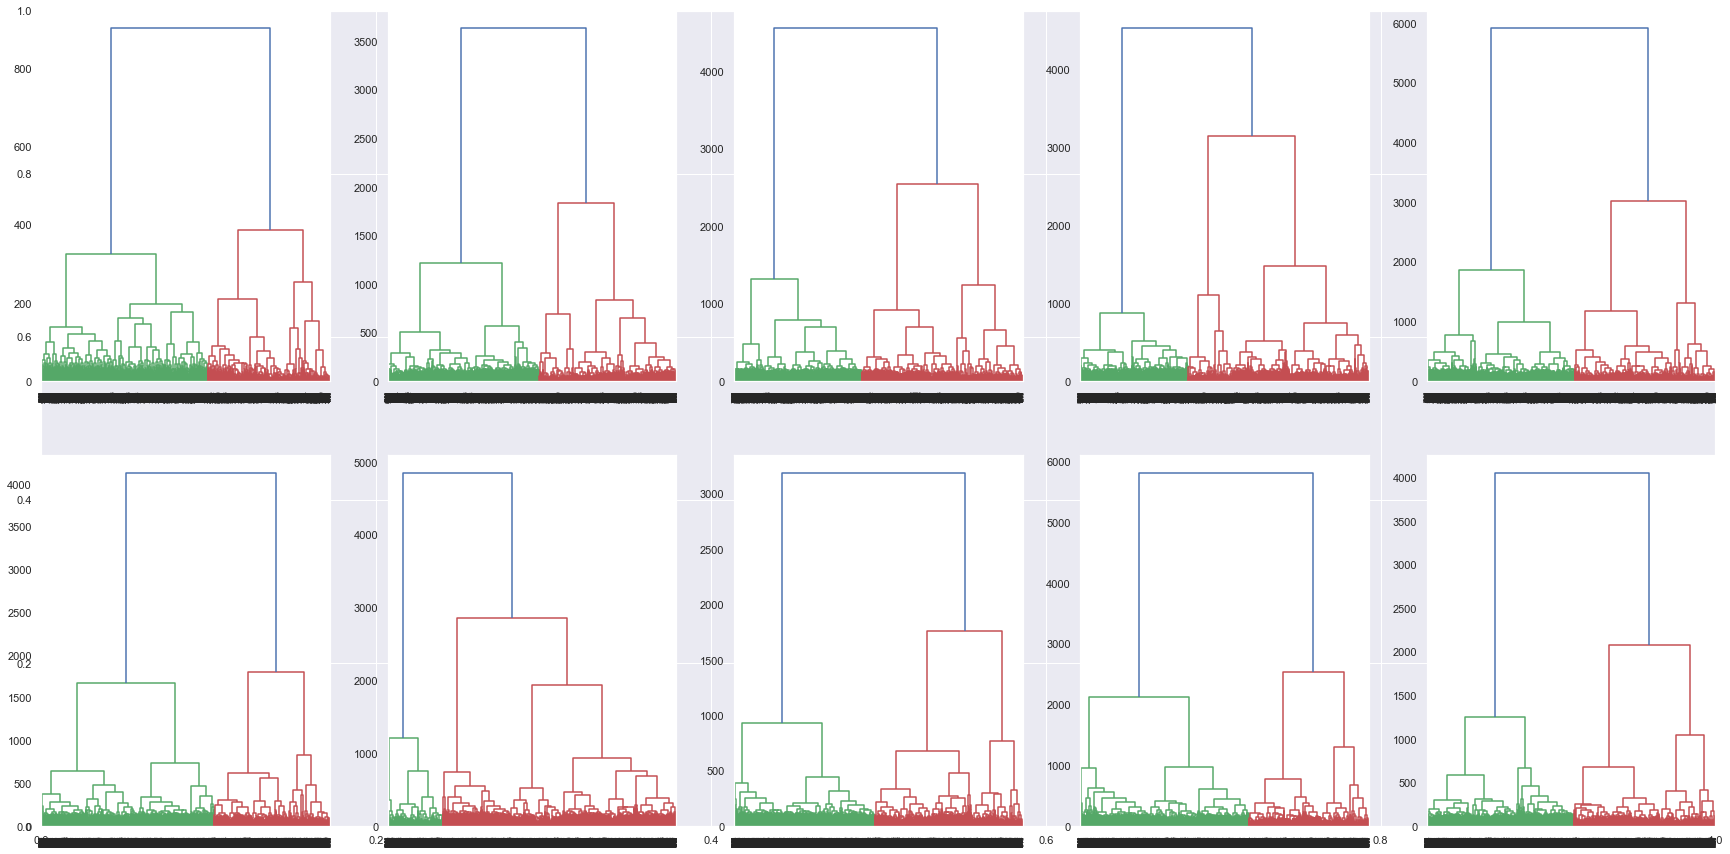

In [24]:
#Clcustering dendrogram
fig, _= plt.subplots(figsize=(30, 15))
ax1 = fig.add_subplot(2, 5, 1)
ax1 = dendrogram(Z_L1_Gluta_ind)

ax2 = fig.add_subplot(2, 5, 2)
ax2 = dendrogram(Z_L23_Gluta_ind)

ax3 = fig.add_subplot(2, 5, 3)
ax3 = dendrogram(Z_L4_Gluta_ind)

ax4 = fig.add_subplot(2, 5, 4)
ax4 = dendrogram(Z_L5_Gluta_ind)

ax5 = fig.add_subplot(2, 5, 5)
ax5 = dendrogram(Z_L6_Gluta_ind)

ax6 = fig.add_subplot(2, 5, 6)
ax6 = dendrogram(Z_L1_Gaba_ind)

ax7 = fig.add_subplot(2, 5, 7)
ax7 = dendrogram(Z_L23_Gaba_ind)

ax8 = fig.add_subplot(2, 5, 8)
ax8 = dendrogram(Z_L4_Gaba_ind)

ax9 = fig.add_subplot(2, 5, 9)
ax9 = dendrogram(Z_L5_Gaba_ind)

ax10 = fig.add_subplot(2, 5, 10)
ax10 = dendrogram(Z_L6_Gaba_ind)

plt.show()

In [0]:
#Clustering
Glu_L1_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=200).fit(L1_Gluta)
Glu_L23_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=500).fit(L23_Gluta)
Glu_L4_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=800).fit(L4_Gluta)
Glu_L5_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=700).fit(L5_Gluta)
Glu_L6_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=900).fit(L6_Gluta)

Gaba_L1_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=1000).fit(L1_Gaba)
Gaba_L23_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=1000).fit(L23_Gaba)
Gaba_L4_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=600).fit(L1_Gaba)
Gaba_L5_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=1000).fit(L1_Gaba)
Gaba_L6_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=1000).fit(L1_Gaba)

In [0]:
Glu_L1_label = Glu_L1_clust.labels_
Glu_L23_label = Glu_L23_clust.labels_
Glu_L4_label = Glu_L4_clust.labels_
Glu_L5_label = Glu_L5_clust.labels_
Glu_L6_label = Glu_L6_clust.labels_

Gaba_L1_label = Gaba_L1_clust.labels_
Gaba_L23_label = Gaba_L23_clust.labels_
Gaba_L4_label = Gaba_L4_clust.labels_
Gaba_L5_label = Gaba_L5_clust.labels_
Gaba_L6_label = Gaba_L6_clust.labels_

In [ ]:
On going......